In [2]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt
import os 
import pandas as pd
from collections import Counter
from scipy.interpolate import make_interp_spline, BSpline

# Pickle dump 
import pickle

In [62]:
from matplotlib.figure import figaspect


lsjpeg  = lambda path   : [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.jpeg') or f.endswith('.jpg')]
norm    = lambda I      : cv2.normalize(I, None, 0, 1, cv2.NORM_MINMAX, cv2.CV_32F)
read    = lambda f      : norm(cv2.imread(f, 0))
dct     = lambda I      : cv2.dct(I)
idct    = lambda I      : cv2.idct(I)
first   = lambda x      : int(str("{:.2e}".format(x))[0]) if x > 0 else 0
firsts  = lambda A      : [first(a) for a in A]
hist    = lambda I      : np.histogram(firsts(I.ravel()), bins=range(11))[0][1:]
pdf     = lambda h      : h/np.sum(h)
ben     = lambda        : np.log10(1 + 1/np.arange(1, 10))
ssd     = lambda A, B   : np.sum([pow(x-y,2) for x, y in zip(A, B)])

class plot:
    image       = lambda I   : plt.imshow(I, cmap='gray')
    
    @classmethod
    def multibar(cls, X, xticks=range(1,10), title=None):
        width = 1/(len(X)+1)
        for i, x in enumerate(X):
            x_axis = np.arange(1, len(x["data"])+1) + i*width
            plt.bar(x_axis, x["data"], width=width, label=x["name"])
        if title:
            plt.title(title)
        plt.xticks(xticks)
        plt.legend()
    
    compare     = lambda f: plot.multibar([{"data": f, "name": "This"}, {"data": ben(), "name": "Benford"}])

    @classmethod
    def study1(cls, df, type='box', alpha=0.25, log=True):
        # Accumulate all dct_probs in a single list
        dct_probs = []
        for i in range(0, 9):
            dct_probs.append([])
        for j, r in df.iterrows():
            probs = list(r["analysis"]["dct"]["probs"])
            for i in range(0, 9):
                dct_probs[i].append(probs[i])
        
        if type == 'box':
            plt.boxplot(dct_probs)
            plt.xticks(range(1, 10))
        elif type == 'violin':
            plt.violinplot(dct_probs, showmeans=True, showmedians=False)
            plt.xticks(range(1, 10))
        
        if log: plt.yscale('log')
        plt.bar(range(1, 10), ben(), color='grey', alpha=0.15)

    @classmethod
    def study2(cls, df, type='box', alpha=0.25, log=True):
        dct_probs = []
        for i in range(0, 9):
            dct_probs.append([])
        for j, r in df.iterrows():
            probs = list(r["analysis"]["dct"]["probs"])
            for i in range(0, 9):
                norm_prob = probs[i]/ben()[i]
                dct_probs[i].append(norm_prob)

        if type == 'box':
            plt.boxplot(dct_probs)
            plt.xticks(range(1, 10))
        elif type == 'violin':
            plt.violinplot(dct_probs, showmeans=True, showmedians=False)
            plt.xticks(range(1, 10))

        if log: plt.yscale('log')
        
    @classmethod
    def study3(cls, df):
        errors = []
        for j, r in df.iterrows():
            error = r["analysis"]["dct"]["error"]
            errors.append(error)
        plt.hist(errors, bins=10)

    @classmethod
    def study4(cls, df):
        # Create 10 subplots for each digit 1-9 and plot the error distribution for each digit in a separate subplot
        # Share the x-axis

        # Create 10 subplots
        fig, axs = plt.subplots(10, 1, sharex=True)
        fig.set_size_inches(10, 18)

        # Sort dataframe by r["width"]
        df = df.sort_values(by=['width'])

        # Get a list of all widths
        widths = df["width"].unique()

        # For each digit 
        for i in range(0, 9):

            probs = []
            errors = []

            # For each width
            for w in widths:
                    
                    # Get all the probs[i] for the current width
                    probs.append(df[df["width"] == w]["analysis"].apply(lambda x: x["dct"]["probs"][i]))

            # Plot the error distribution for the current digit
            axs[i].plot(widths, [np.mean(p) for p in probs], color='blue')

            # Plot the Benford distribution
            axs[i].plot(widths, [ben()[i] for _ in range(0, len(widths))], color='red')

            # Set the title
            axs[i].set_title("Digit {}".format(i+1))

        # For each digit 
        for i in range(0, 9):
            window = []

            sliding_scale = 3

            # For every 5 widths 
            for j in range(0, len(widths), sliding_scale):
            
                # Get the min prob for the current digit in the current width and 4 next widths
                min_prob = min([min(df[df["width"] == w]["analysis"].apply(lambda x: x["dct"]["probs"][i])) for w in widths[j:j+sliding_scale]])

                # Get the max prob for the current digit in the current width and 4 next widths
                max_prob = max([max(df[df["width"] == w]["analysis"].apply(lambda x: x["dct"]["probs"][i])) for w in widths[j:j+sliding_scale]])

                window.append({'min': min_prob, 'max': max_prob, 'width': widths[j]})

            # Plot the envolpe of the min and max probs and fill it with a color
            axs[i].fill_between([w['width'] for w in window], [w['min'] for w in window], [w['max'] for w in window], color='grey', alpha=0.25)


        # For each width 
        for w in widths:
            # Get the mean error for the current width
            errors.append(df[df["width"] == w]["analysis"].apply(lambda x: x["dct"]["error"]).mean())

        # Plot the error in the last subplot
        axs[9].plot(widths, errors, color='blue')

        # Set x-ticks for all the subplots as the widths
        for ax in axs:
            # Set every 10th x-tick
            ax.set_xticks(widths[::20])

        # Set the title
        axs[9].set_title("Error")            
        plt.subplots_adjust(wspace=0, hspace=0.5)

    @classmethod
    def study5(cls, df, log=False, xstep=20):
        # Create 10 subplots for each digit 1-9 and plot the error distribution for each digit in a separate subplot
        # Share the x-axis

        # Create 10 subplots
        fig = plt.figure()
        fig.set_size_inches(18, 10)

        # Sort dataframe by r["width"]
        df = df.sort_values(by=['width'])

        # Get a list of all widths
        widths = df["width"].unique()

        # For each digit 
        for i in range(0, 9):

            probs = []
            errors = []

            # For each width
            for w in widths:
                    
                    # Get all the probs[i] for the current width
                    probs.append(df[df["width"] == w]["analysis"].apply(lambda x: (x["dct"]["probs"][i] - ben()[i])/ben()[i]))

            # Create smooth spline for the current digit
            xnew = np.linspace(widths.min(), widths.max(), 800)
            spl = make_interp_spline(widths, [np.mean(p) for p in probs], k=3)
            power_smooth = spl(xnew)
            

            # Plot the error distribution for the current digit
            plt.plot(xnew, power_smooth, label="Digit {}".format(i+1))

            # # Plot the Benford distribution
            # plt[i].plot(widths, [0 for _ in range(0, len(widths))], color='red')

        # Draw an envelope in +- 10% of the Benford distribution
        plt.fill_between(xnew, [-0.1 for _ in range(0, len(xnew))], [0.1 for _ in range(0, len(xnew))], color='grey', alpha=0.25)

        # Draw a lighter envelope in +- 12.5% of the Benford distribution
        plt.fill_between(xnew, [-0.125 for _ in range(0, len(xnew))], [0.125 for _ in range(0, len(xnew))], color='grey', alpha=0.1)

        # Set x-ticks for all the subplots as the widths
        plt.xticks(widths[::xstep])

        # Set x-axis to log scale
        if log: plt.xscale('log')
        
        plt.legend()
        

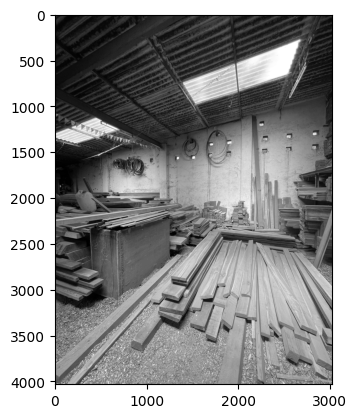

In [3]:
I = read('data/IMG_0026.jpeg')
plot.image(I)

In [ ]:
probs = pdf(hist(I))
error = ssd(probs, ben())

plot.compare(probs)
print(error)

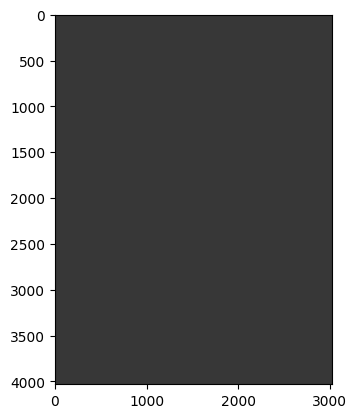

In [4]:
M = dct(I)
plot.image(M)

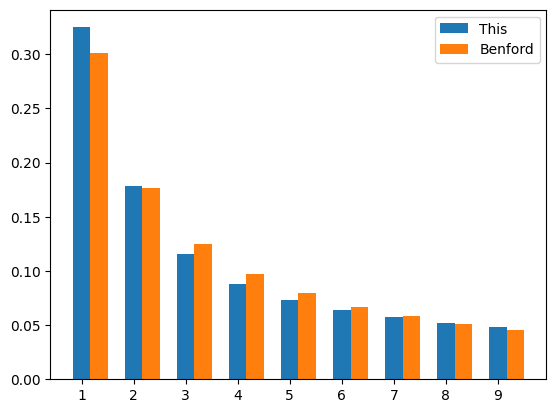

0.0007955814526799957


In [5]:
probs = pdf(hist(M))
error = ssd(probs, ben())

plot.compare(probs)
print(error)

In [4]:
def image_stats(file):
    I = read(file)
    pre_probs = pdf(hist(I))
    pre_error = ssd(pre_probs, ben())

    M = dct(I)
    dct_probs = pdf(hist(M))
    dct_error = ssd(dct_probs, ben())
    
    stats = { 
        "file": file, 
        "width": I.shape[1],
        "height": I.shape[0],
        "analysis": {
            "pre": {
                "probs": pre_probs,
                "error": pre_error
            }, 
            "dct": {
                "probs": dct_probs,
                "error": dct_error
            }
        }
    }

    return stats
    

In [61]:
image_stats('data/IMG_0026.jpeg')

{'file': 'data/IMG_0026.jpeg',
 'width': 3024,
 'height': 4032,
 'analysis': {'pre': {'probs': array([0.16177605, 0.13081337, 0.12501364, 0.10208528, 0.1078571 ,
          0.14063051, 0.13394351, 0.06400494, 0.0338756 ]),
   'error': 0.033795137840384584},
  'dct': {'probs': array([0.32483227, 0.17815522, 0.11567405, 0.08771422, 0.07295284,
          0.06380462, 0.05707369, 0.05199802, 0.04779508]),
   'error': 0.0007955814526799957}}}

In [5]:
def batch_stats(files):
    batch = []

    for i, file in enumerate(files):
        print(f"Analysing file {i+1}/{len(files)} ..", end='\r')
        batch.append(image_stats(file))
    df = pd.DataFrame(batch)
    print(f"Analysing {i+1}/{len(files)} .. Done!")
    return df

In [42]:
files = lsjpeg('data')
stats = batch_stats(files[:20])

Analysing 20/20 .. Done!


In [29]:
# Save stats to pickle dump 
with open('stats.pkl', 'wb') as f:
    pickle.dump(stats, f)

In [60]:
# Load stats from pickle dump
file = 'IMG_0026_stats.pkl'
with open(file, 'rb') as f:
    stats = pickle.load(f)

In [50]:
stats

,file,width,height,analysis
0,IMG_0030/86_0.578.jpg,2332,1748,"{'pre': {'probs': [0.15130177972754333, 0.1561..."
1,IMG_0030/9_0.96.jpg,3872,2904,"{'pre': {'probs': [0.15250463990537855, 0.1561..."
2,IMG_0030/79_0.613.jpg,2472,1854,"{'pre': {'probs': [0.15138535387509633, 0.1560..."
3,IMG_0030/146_0.281.jpg,1132,848,"{'pre': {'probs': [0.1492273808952746, 0.15573..."
4,IMG_0030/74_0.638.jpg,2572,1928,"{'pre': {'probs': [0.1514739156657899, 0.15601..."
...,...,...,...,...
196,IMG_0030/163_0.196.jpg,792,594,"{'pre': {'probs': [0.14677855061366005, 0.1561..."
197,IMG_0030/35_0.831.jpg,3352,2514,"{'pre': {'probs': [0.1520181760681769, 0.15612..."
198,IMG_0030/92_0.549.jpg,2212,1658,"{'pre': {'probs': [0.151219041964995, 0.155952..."
199,IMG_0030/132_0.35.jpg,1412,1058,"{'pre': {'probs': [0.1502447026877422, 0.15588..."


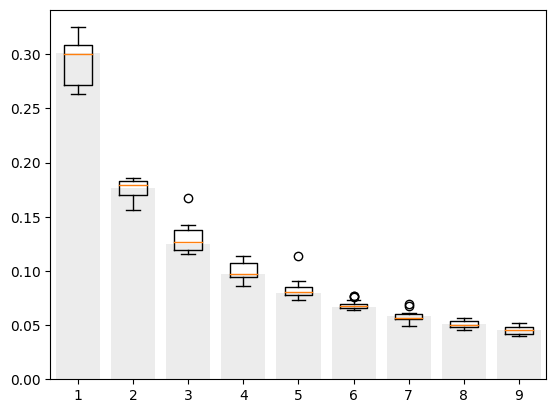

In [63]:
plot.study1(stats, type='box', log=False)
plt.savefig('output/' + file + '_study1A.png', dpi=300)

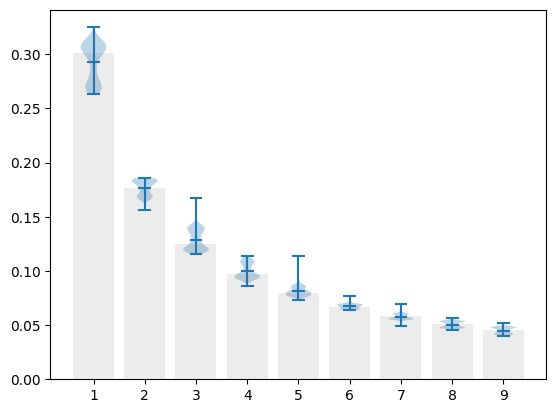

In [56]:
plot.study1(stats, type='violin', log=False)

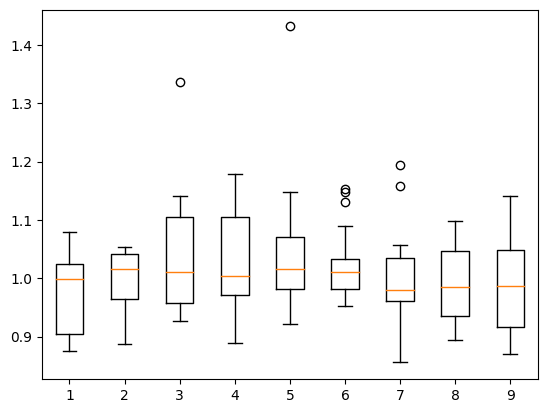

In [57]:
plot.study2(stats, type='box', log=False)

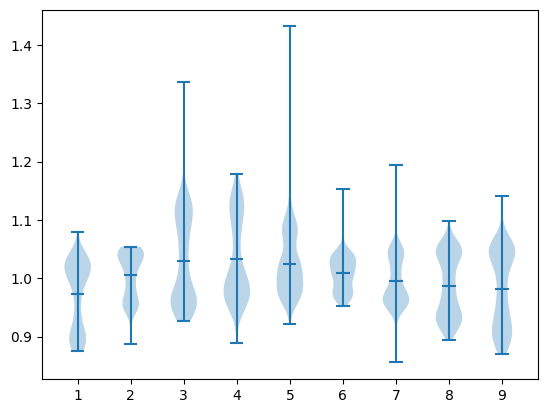

In [58]:
plot.study2(stats, type='violin', log=False)

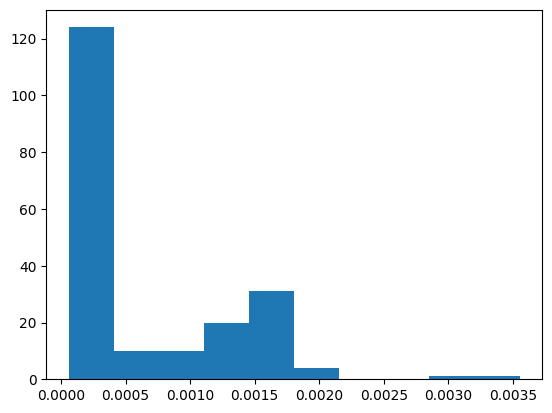

In [59]:
plot.study3(stats)

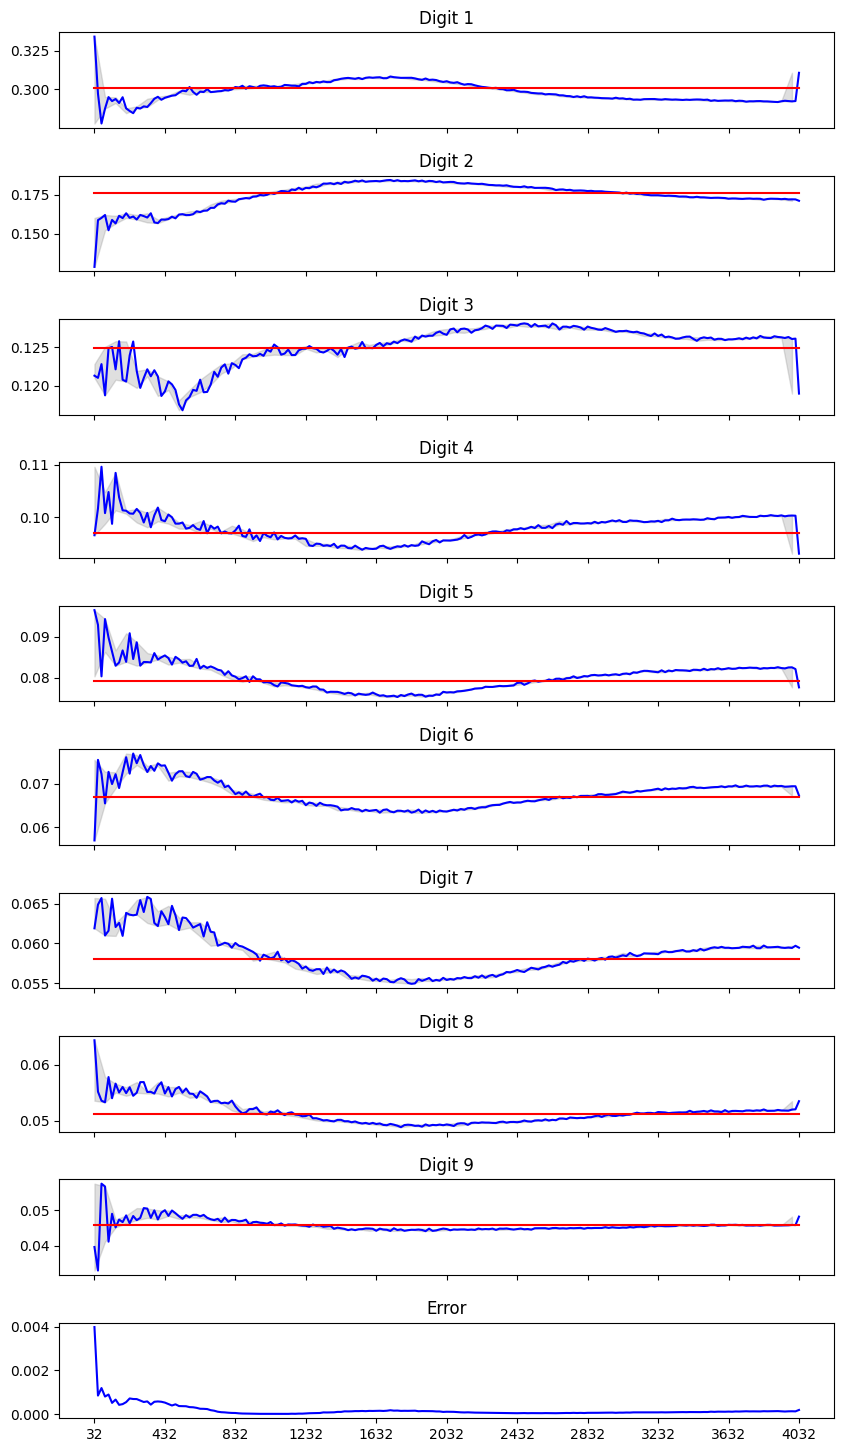

In [51]:
plot.study4(stats)

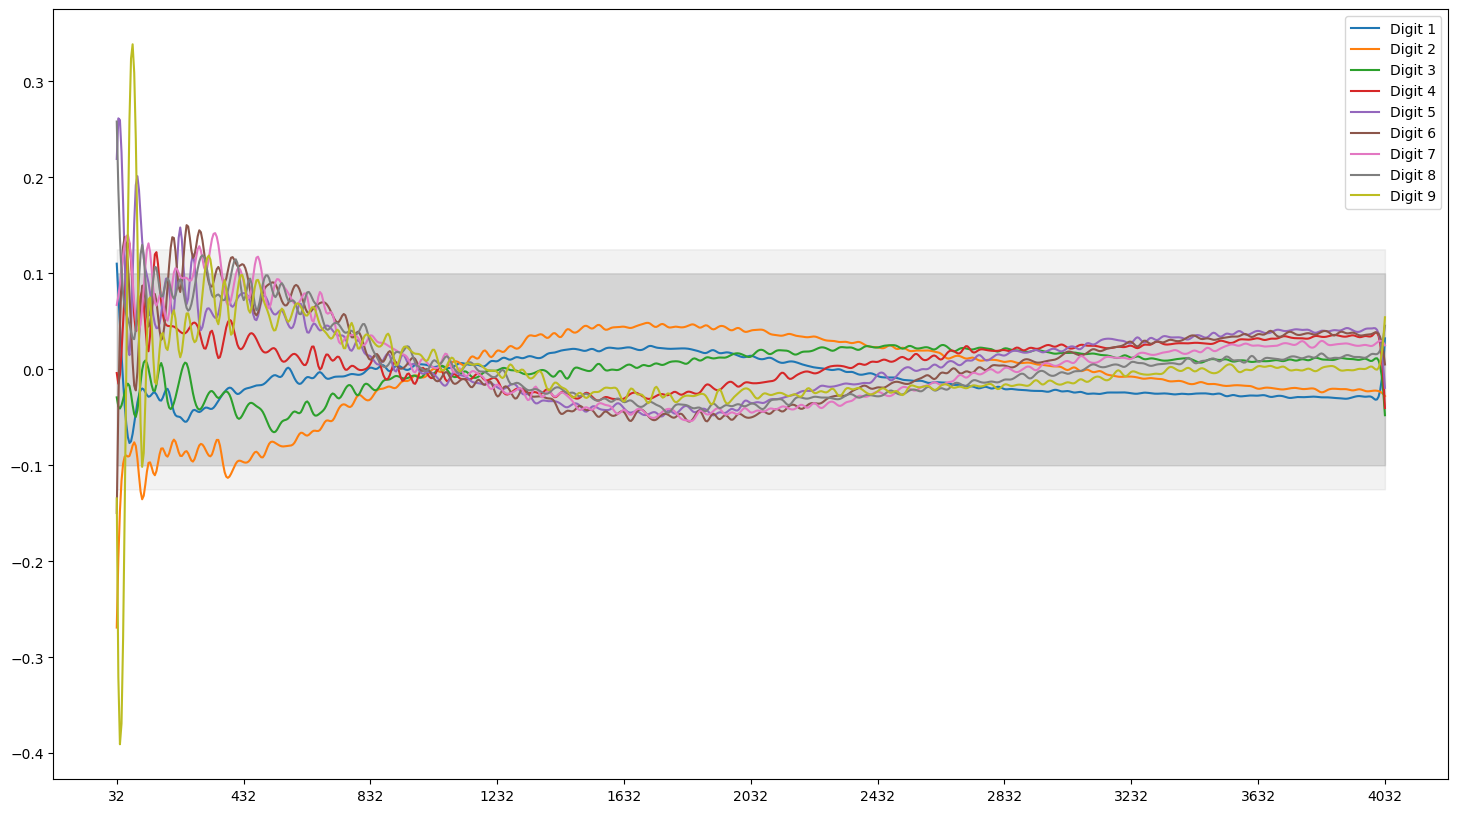

In [52]:
# Sort stats by width
stats = stats.sort_values(by=['width'])
plot.study5(stats, log=False, xstep=20)